# Import Basic Libraries


In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor  
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import datetime
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression

In [0]:
train=pd.read_excel("Data_Train.xlsx")
test=pd.read_excel("Test_set.xlsx")
sample=pd.read_excel("Sample_submission.xlsx")

In [4]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [0]:
len_train=train.shape[0]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
Airline            10683 non-null object
Date_of_Journey    10683 non-null object
Source             10683 non-null object
Destination        10683 non-null object
Route              10682 non-null object
Dep_Time           10683 non-null object
Arrival_Time       10683 non-null object
Duration           10683 non-null object
Total_Stops        10682 non-null object
Additional_Info    10683 non-null object
Price              10683 non-null int64
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
print(train.shape)
train.describe()

(10683, 11)


,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [8]:
print(test.shape)
test.head()

(2671, 10)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
Airline            2671 non-null object
Date_of_Journey    2671 non-null object
Source             2671 non-null object
Destination        2671 non-null object
Route              2671 non-null object
Dep_Time           2671 non-null object
Arrival_Time       2671 non-null object
Duration           2671 non-null object
Total_Stops        2671 non-null object
Additional_Info    2671 non-null object
dtypes: object(10)
memory usage: 208.8+ KB


In [0]:
train=train.append(test)

In [11]:
train.shape

(13354, 11)

## EDA

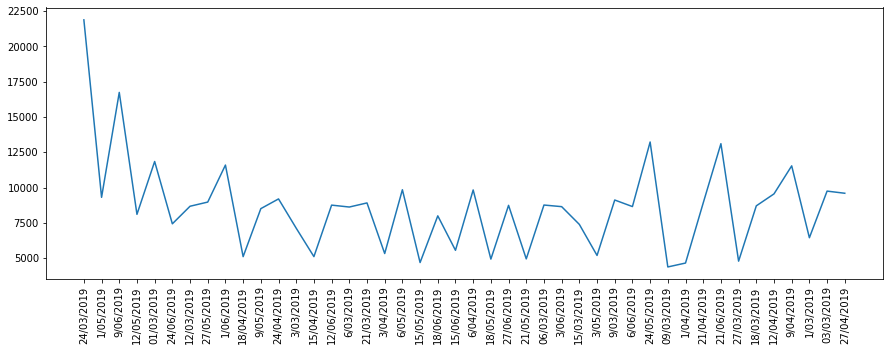

In [12]:
#Date of journey
plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
plt.plot(train.Date_of_Journey.unique(),train.groupby(['Date_of_Journey']).mean())

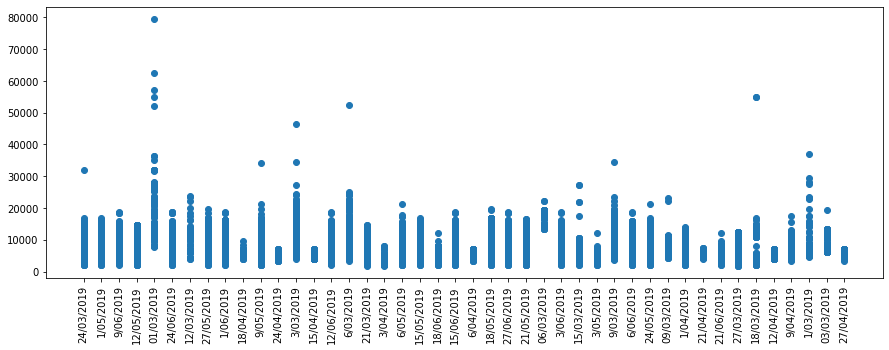

In [13]:
# Date of journey VS Price
plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
plt.scatter(train.Date_of_Journey, train.Price)

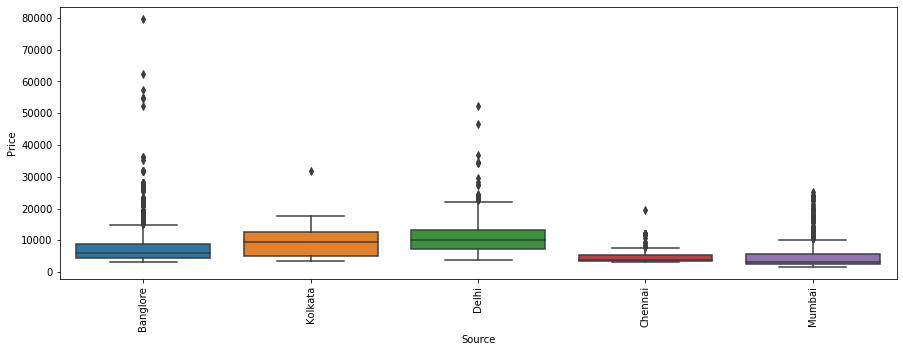

In [14]:
#Source VS Price
plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.boxplot(train.Source, train.Price )

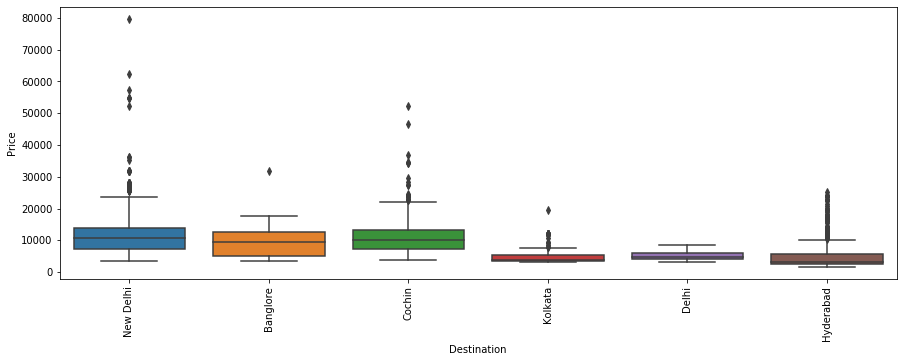

In [15]:
#Destination VS Price
plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.boxplot(train.Destination, train.Price )

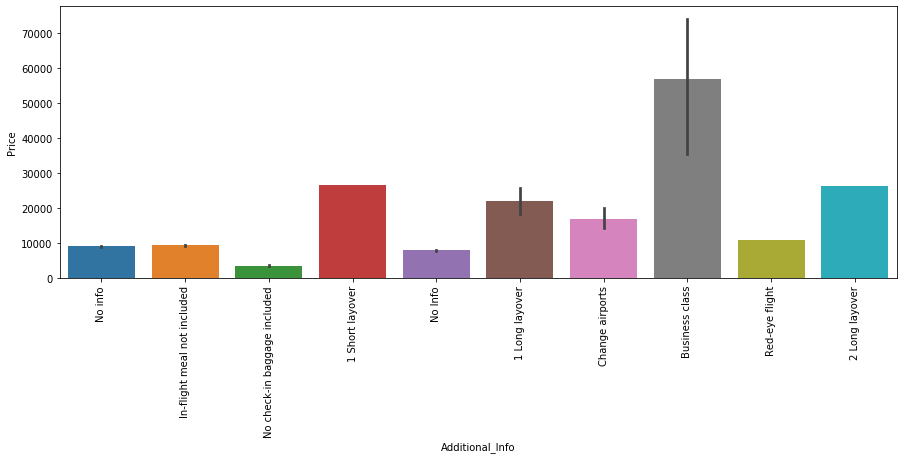

In [16]:
#Additional_info VS Price
plt.subplots(figsize=[15,5])
plt.xticks(rotation=90)
sns.barplot(train.Additional_Info, train.Price )

#Data PreProcessing

In [0]:
train.Dep_Time=pd.to_datetime(train.Dep_Time, format= '%H:%M').dt.time

In [18]:
train.Dep_Time

0       22:20:00
1       05:50:00
2       09:25:00
3       18:05:00
4       16:50:00
          ...   
2666    20:30:00
2667    14:20:00
2668    21:50:00
2669    04:00:00
2670    04:55:00
Name: Dep_Time, Length: 13354, dtype: object

In [0]:
train.Arrival_Time=train.Arrival_Time.str.slice(0,6)
train.Arrival_Time=train.Arrival_Time.str.strip()
train.Arrival_Time=pd.to_datetime(train.Arrival_Time, format = '%H:%M').dt.time

In [20]:
train.Arrival_Time

0       01:10:00
1       13:15:00
2       04:25:00
3       23:30:00
4       21:35:00
          ...   
2666    20:25:00
2667    16:55:00
2668    04:25:00
2669    19:15:00
2670    19:15:00
Name: Arrival_Time, Length: 13354, dtype: object

In [0]:
train.Date_of_Journey=pd.to_datetime(train.Date_of_Journey,format='%d/%m/%Y').dt.date

Converting hours into minutes and adding them together

In [0]:
minute=train['Duration'].str.slice(3,).str.extract('(\d+)')
hour=train['Duration'].str.extract('(\d+)').astype('int')
minute=minute.fillna(0) 
train['Duration']=minute.astype('int')+hour*60

In [23]:
train.Duration

0        170
1        445
2       1140
3        325
4        285
        ... 
2666    1435
2667     155
2668     395
2669     915
2670     860
Name: Duration, Length: 13354, dtype: int64

Here I have created a new variable called 'Date_of_Arrival'. I added Date_of_Journey with the time duration.

In [0]:
train['Date_of_Arrival']=train.apply(lambda r : pd.datetime.combine(r['Date_of_Journey'],r['Dep_Time']),1) + pd.to_timedelta(train.Duration,unit='m')
train['Date_of_Arrival']=train.Date_of_Arrival.dt.date

In [25]:
train.Date_of_Arrival

0       2019-03-25
1       2019-05-01
2       2019-06-10
3       2019-05-12
4       2019-03-01
           ...    
2666    2019-06-07
2667    2019-03-27
2668    2019-03-07
2669    2019-03-06
2670    2019-06-15
Name: Date_of_Arrival, Length: 13354, dtype: object

Total count of unique stops


In [26]:
train.Total_Stops.value_counts()

1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

In [0]:
dic={'non-stop':0,'2 stops':2,'1 stop':1,'3 stops':3,'4 stops': 4}
train['Total_Stops']=train.Total_Stops.map(dic)
train.Total_Stops=train.Total_Stops.astype('category')

In [0]:
r=train.Airline.str.split(' ',expand=True).get(2)

In [29]:
r.unique()

array([None, 'economy', 'Business', 'Premium'], dtype=object)

In [0]:

d={None:'Economy','Premium': 'Premium Economy','economy':'Premium Economy','Business':'Business' }
r=r.map(d)
train['Class']=r
train.Class=train.Class.astype('category')

In [0]:
train.loc[train.Additional_Info=="No info",'Additional_Info']="No Info"

In [0]:
train.Airline=train.Airline.astype('category')

Created A column 'Same_day_travel'

In [0]:
train['Same_day_travel']=train.Date_of_Arrival-train.Date_of_Journey
train['Same_day_travel']=train.Same_day_travel.astype('category')

In [0]:
train['weekday_journey']=train['Date_of_Journey'].apply(lambda x: x.weekday())
train['weekday_arrival']=train['Date_of_Arrival'].apply(lambda x: x.weekday())

In [0]:
train['Year']=pd.DatetimeIndex(train['Date_of_Journey']).year
train['month_of_journey']=pd.DatetimeIndex(train['Date_of_Journey']).month
train['month_of_Arrival']=pd.DatetimeIndex(train['Date_of_Arrival']).month
train['day_of_Arrival']=pd.DatetimeIndex(train['Date_of_Arrival']).day
train['day_of_journey']=pd.DatetimeIndex(train['Date_of_Journey']).day

In [36]:
train.shape

(13354, 21)

Now checking the null values of the data set

In [37]:
train.isnull().sum()

Additional_Info        0
Airline                0
Arrival_Time           0
Date_of_Journey        0
Dep_Time               0
Destination            0
Duration               0
Price               2671
Route                  1
Source                 0
Total_Stops            1
Date_of_Arrival        0
Class                  0
Same_day_travel        0
weekday_journey        0
weekday_arrival        0
Year                   0
month_of_journey       0
month_of_Arrival       0
day_of_Arrival         0
day_of_journey         0
dtype: int64

In [0]:
train.Route=train.Route.fillna('DEL → MAA → COK')
train.loc[train.Total_Stops.isnull(),'Total_Stops']=1

Dummy variable

In [0]:
df=pd.get_dummies(train)

In [0]:
train_df=df[:len_train]
test_df=df[len_train:]

In [0]:
x=train_df.drop('Price',axis=1)
y=train_df['Price']

In [0]:
X=np.array(x)
Y=np.array(y)

In [0]:
import math

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## Models

Linear Regression

In [0]:
reg=LinearRegression()

In [45]:
reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Gradient Boosting


In [0]:
xgb=XGBRegressor(learning_rate =0.1, 
      n_estimators=1500, max_depth=12, min_child_weight=1,gamma=0, reg_alpha=2e-5,
      subsample=0.8,colsample_bytree=0.8,
      nthread=4,scale_pos_weight=1,seed=27,verbose=True,random_state=10)

In [0]:
grb=GradientBoostingRegressor(learning_rate=0.1,n_estimators=400, max_depth=12
                              ,subsample=0.8,
                              verbose=False,random_state=10)

Random Forest

In [0]:
RF=RandomForestRegressor(n_estimators=3000, oob_score = False, n_jobs = -1,random_state =50,
                         max_features = "auto", min_samples_leaf = 2,warm_start=True,criterion='mse',max_depth=50)

In [0]:
RF.fit(X,Y)
y_pred=RF.predict(X)

In [52]:
rmsle(y,y_pred)

0.07048471929462403

In [53]:
1-0.0704

0.9296

In [54]:
y_pred

array([ 5234.78516929,  7407.72125093, 13880.59530794, ...,
        7228.81083333, 18548.68114953, 12183.67936712])

In [0]:
#avg = sum(digits)/len(digits)
#from statistics import mean
#Predict=mean.predict(np.array(test_df.drop('Price',axis=1)))

In [56]:
Price_pred = pd.DataFrame(y_pred, columns = ['Price']) # Converting to dataframe
print(Price_pred.head())

          Price
0   5234.785169
1   7407.721251
2  13880.595308
3   6318.376117
4  11294.010912


In [57]:
len(Price_pred)

10683

In [0]:
Predict=RF.predict(np.array(test_df.drop('Price',axis=1)))

In [0]:
Predict=Predict.astype(int)

In [0]:
Submission=pd.DataFrame(Predict,columns=['Price'])

In [61]:
len(Submission)

2671

In [62]:
import os
os.getcwd()

'/content'

In [0]:
Submission.to_csv('submisssion1.csv',index=False)